# Лабораторная работа 3-4

Выполнил Лисин Роман, М8О-406Б-20

### Выбор набора данных для классификации и обоснование его выбора

Я выбрал и скачал датасет Heart Disease Health Indicators с сайта https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset/, потому что здоровье человека является очень важным фактором в жизни, и важно вовремя выявлять проблемы со здоровьем. Будем решать задачу выявления пациентов с высоким риском сердечного приступа.

In [1]:
import pandas as pd

In [2]:
!pip install kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!echo '{"username":"midlow","key":"19e4a7b3c26e4d040a5179c6b36318cd"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexteboul/heart-disease-health-indicators-dataset
!unzip heart-disease-health-indicators-dataset.zip
!rm *.zip
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

rm: cannot remove '/root/.kaggle': No such file or directory
  0% 0.00/2.66M [00:00<?, ?B/s]
100% 2.66M/2.66M [00:00<00:00, 133MB/s]
Archive:  heart-disease-health-indicators-dataset.zip
  inflating: heart_disease_health_indicators_BRFSS2015.csv  


In [3]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
target = 'HeartDiseaseorAttack'

###Выбор метрик качества и обоснование их выбора

Для каждой модели будем подсчитывать:
* Accuracy
* Precision
* Recall

Так как мы решаем задачу предсказания вероятности сердечного приступа, то
нужно максимизировать recall и только accuracy будет недостаточно. Поэтому будем дополнительно оценивать соотношение
precision и recall с помощью PR-curve. Будем оценивать
модель при таком recall = 0.7. Отметим, что классы в данной задаче несбалансированные, потому что людей с такой серьёзной болезнью меньше, чем остальных.

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import numpy as np

In [6]:
def get_metrics(model, X, y_true, threshold=0.5, use_probas=True):

    if use_probas:
        y_pred_probas = model.predict(X)
        if len(y_pred_probas.shape) == 2:
            y_pred_probas = y_pred_probas[:, 1]
        y_pred = y_pred_probas > threshold
    else:
        y_pred = model.predict(X)

    print('Accuracy = ', accuracy_score(y_true, y_pred))
    print('Precision = ', precision_score(y_true, y_pred))
    print('Recall = ', recall_score(y_true, y_pred))

    if use_probas:
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probas)
        plt.figure(figsize=(15, 8))
        plt.xlabel('Recall')
        plt.ylabel('Presicion')
        plt.title('Precision-recall curve')
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.grid()
        plt.plot(recall, precision)

### Создание бейзлайна

Поделим данные на обучающую (80%) и тестовую (20%) выборки.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.drop(target, axis=1)
y = df[target]
assert len(X) == len(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0xDEAD)

In [10]:
X_train.shape, X_test.shape

((202944, 21), (50736, 21))

####Опишем константный предиктор и посмотрим на результат.

In [11]:
class ConstantPredictor:

    def predict(self, X):
        predictions = [0] * len(X)  # всегда предсказываем "0" (нет риска приступа)
        return np.array(predictions)

Accuracy =  0.9043479974771366
Precision =  0.0
Recall =  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


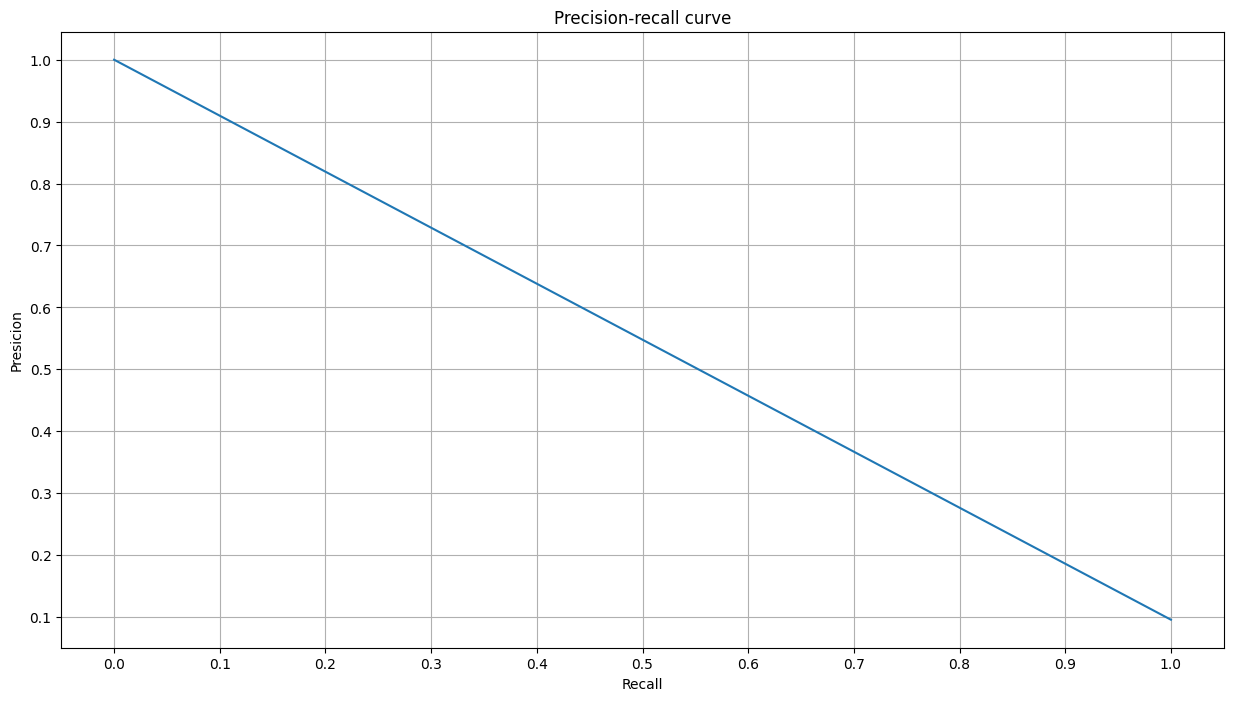

In [12]:
get_metrics(ConstantPredictor(), X_test, y_test, threshold=0.5)

Убедились, что только метрики accuracy нам будет недостаточно. Очевидно, что людей, у которых не будет сердечного приступа больше.

####Обучим модели линейной и логистической регрессии из sklearn

Accuracy =  0.9060233364869127
Precision =  0.7135678391959799
Recall =  0.029260251390892233


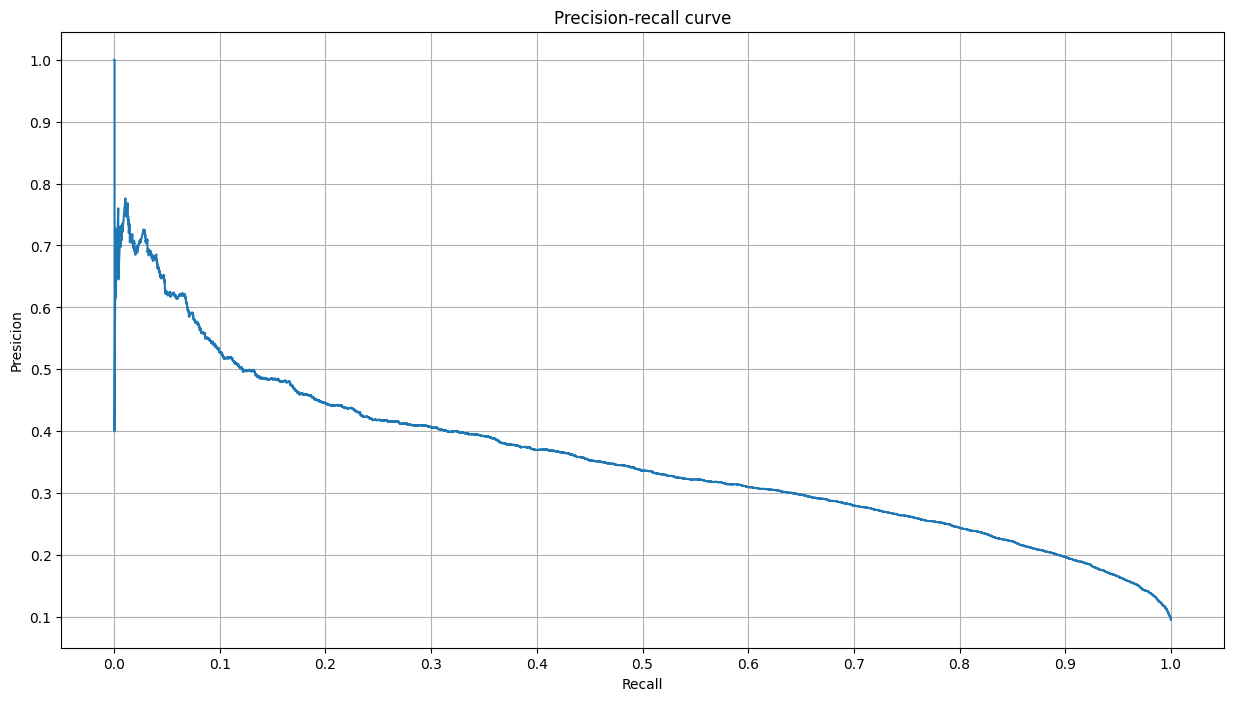

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
get_metrics(model, X_test, y_test, threshold=0.5)

Accuracy =  0.9056291390728477
Precision =  0.5292529252925292
Recall =  0.12116216773130023


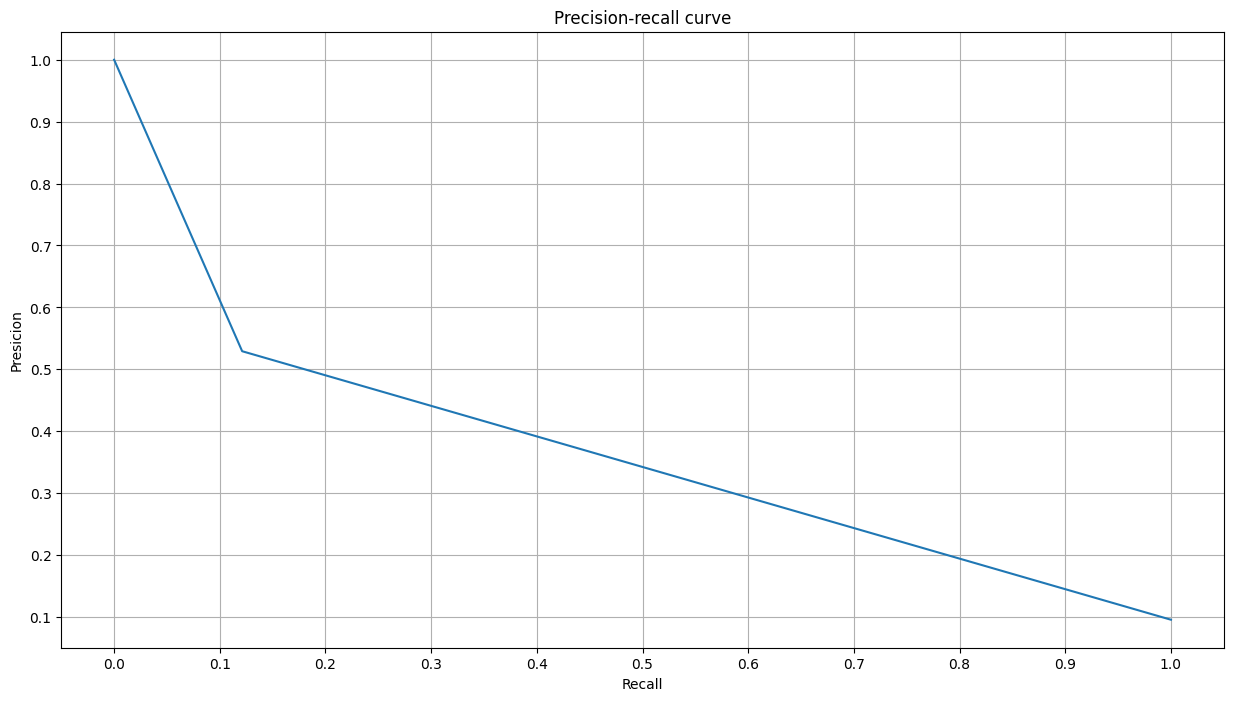

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver="liblinear")
model.fit(X_train, y_train)
get_metrics(model, X_test, y_test, threshold=0.5)

Модели линейной и логистической регресии хоть и могут иметь меньшую точность на определённых выборках, чем константная модель, но они могут работать на любых тестовых данных и выдавать разные предсказания. Следовательно, несомненно модели линейной и логистической регресии лучше константной.

###Улучшение бейзлайна

Посмотрим на данные внимательнее. Заметим, что можно разбить поля на численные и категориальные.

In [15]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [16]:
numerical_features = ['MentHlth', 'PhysHlth', 'BMI']
categorical_features = [feat for feat in list(df.columns) if feat != target and feat not in numerical_features]

Добавим предобработку данных (preprocessing).

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin

Категориальные фичи преобразуем с помощью one-hot encoding. Причем если признак бинарный, то будем оставлять только один столбец для него. Количественные фичи нормализуем. У фичи BMI распределение нормальное, поэтому приведем его к стандартному нормальному, вычтя матожидание и поделив на стандартное отклонение. Остальные количественные фичи приведем к интервалу [0; 1]

In [18]:
data_preprocessing = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), categorical_features),
    ('stdscale', StandardScaler(), ['BMI']),
    ('minmax', MinMaxScaler(), [feat for feat in numerical_features if feat != 'BMI'])
])

ColumnTransformer возвращает разреженную матрицу. Мы хотим сделать ее нормальной, чтобы ее можно было передавать дальше по пайплайну в модель. Поэтому напишем свой трансформер, который превращает разреженную матрицу в обычный массив.

In [19]:
class ToArrayTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

Обучим и протестируем модели.

In [20]:
from sklearn.linear_model import LinearRegression

model = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('logreg', LinearRegression())
    ]
)

In [21]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke', 'Diabetes',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'GenHlth',
                                                   'DiffWalk', 'Sex', 'Age',
                                                   'Education', 'Income']),
                                                 ('stdscale', StandardScaler(),
                                                  ['BMI']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['MentHlth', 'PhysHlth'])])),
                ('to_array',
                 <__main__.ToArrayTransformer object at 0x7ebfc1613040>),
                ('logreg', LinearRegression())])

Accuracy =  0.9063584042888678
Precision =  0.6613924050632911
Recall =  0.043066144652792085


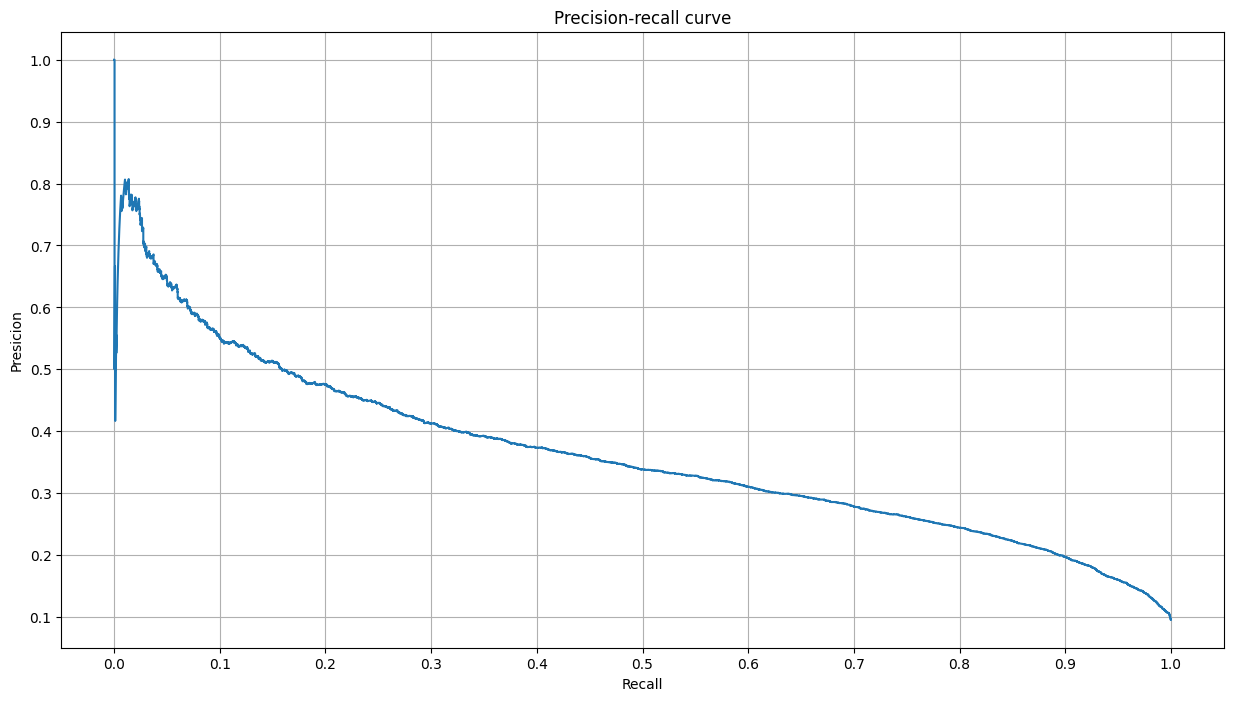

In [22]:
get_metrics(model, X_test, y_test, threshold=0.5)

In [23]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('logreg', LogisticRegression(solver="liblinear", class_weight='balanced'))
    ]
)

In [24]:
model.fit(X_train, y_train);

Accuracy =  0.7545135603910438
Precision =  0.2527322404371585
Recall =  0.8005357510818051


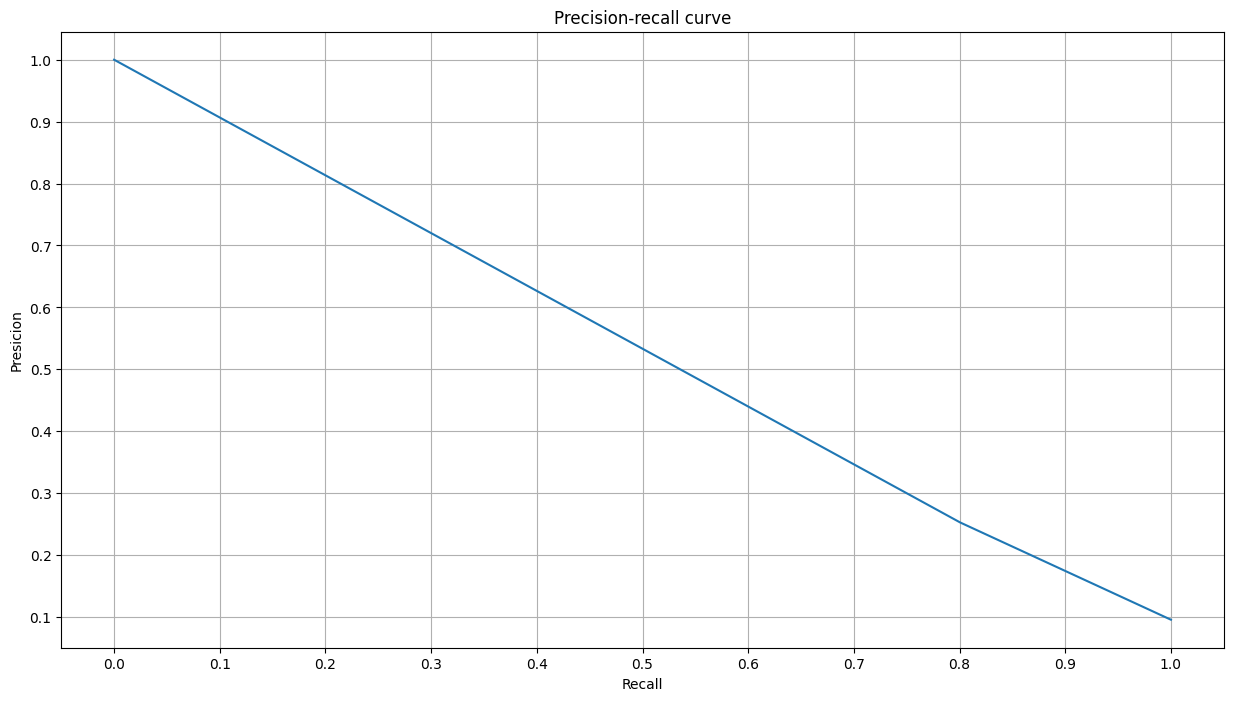

In [25]:
get_metrics(model, X_test, y_test, threshold=0.5)

С помощью предобработки данных получилось немного улучшить соотношение precision/recall, но несущественно.

### Реализация алгоритмов линейной и логистической регрессии

Реализуем регрессии через градиентный спуск.

In [26]:
class CustomLinearRegression:
    def __init__(self, learning_rate=0.001, n_iterations=250):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features + 1)
        X = np.column_stack([np.ones(n_samples), X])

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights)
            d_weights = (1 / n_samples) * np.dot(X.T, (linear_model - y))
            self.weights -= self.learning_rate * d_weights

    def predict(self, X):
        n_samples = X.shape[0]
        X = np.column_stack([np.ones(n_samples), X])
        return np.dot(X, self.weights)

In [27]:
model = CustomLinearRegression()
model.fit(X_train, y_train)

Accuracy =  0.7059484389782403
Precision =  0.20931038465981286
Recall =  0.7467545847929116


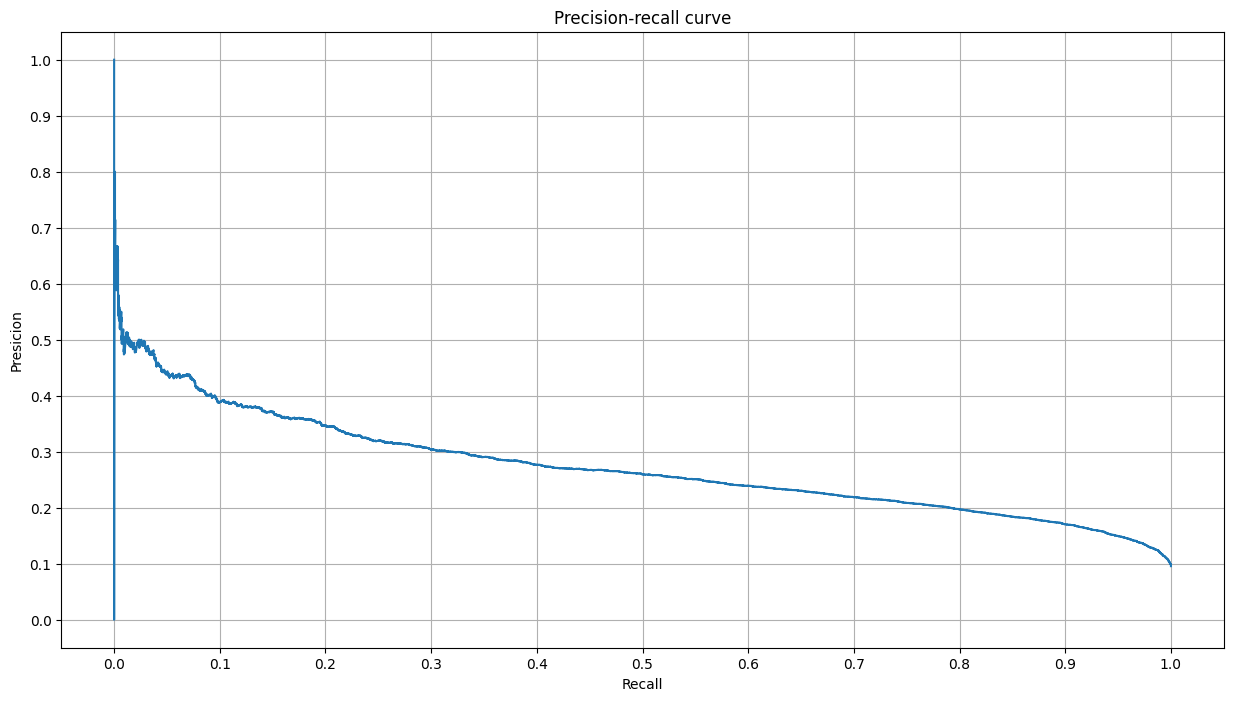

In [28]:
get_metrics(model, X_test, y_test, threshold=0.12)

In [29]:
class CustomLogisticRegression():
    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features + 1)
        X = np.column_stack([np.ones(n_samples), X])

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights)
            y_predicted = self.sigmoid(linear_model)

            d_weights = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            self.weights -= self.learning_rate * d_weights

    def predict(self, X, threshold=0.5):
        n_samples = X.shape[0]
        X = np.column_stack([np.ones(n_samples), X])
        y_predicted = self.sigmoid(np.dot(X, self.weights))
        return y_predicted

In [30]:
model = CustomLogisticRegression()
model.fit(X_train, y_train)

Accuracy =  0.903914380321665
Precision =  0.2962962962962963
Recall =  0.00329692973418504


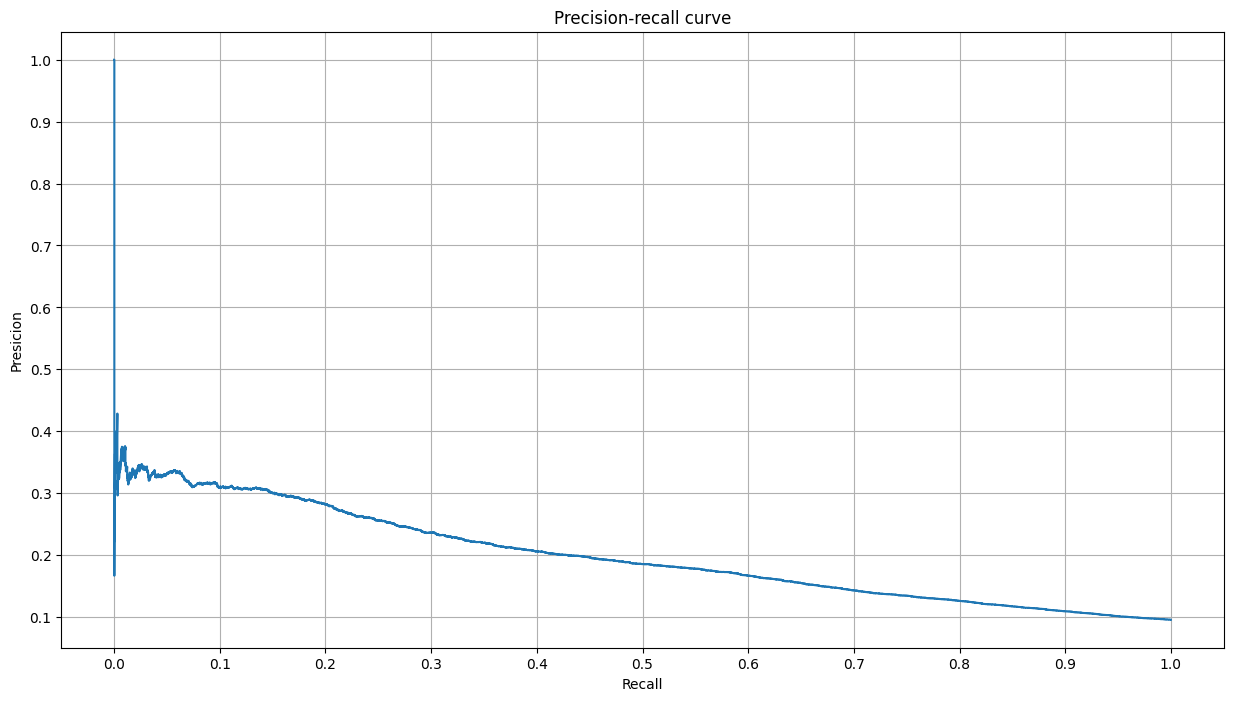

In [31]:
get_metrics(model, X_test, y_test, threshold=0.5)

Сравнивая модели при recall = 0.7, видим, что модели sklearn с предобработкой данных справляются лучше. В итоге, лучший пайплайн - модели sklearn с предобработкой данных. Но соотношение precision/recall оставляет желать лучшего.

###Реализация алгоритмов (дерево решений, случайный лес, градиентный бустинг)

Реализуем дерево решений. Из sklearn использую только валидацию перед предсказанием.



In [38]:
from sklearn.utils.validation import check_array


class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


class CustomDecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes))

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None
        parent_gini = self._gini(y)
        best_gini = 1
        best_feature, best_threshold = None, None

        for feature in range(n):
            thresholds, classes = zip(*sorted(zip(X.iloc[:, feature], y)))
            left_counts = [0] * self.n_classes
            right_counts = [np.sum(y == c) for c in range(self.n_classes)]

            for i in range(1, m):
                c = int(classes[i - 1])
                left_counts[c] += 1
                right_counts[c] -= 1
                gini_left = 1.0 - sum(
                    (left_counts[x] / i) ** 2 for x in range(self.n_classes))
                gini_right = 1.0 - sum(
                    (right_counts[x] / (m - i)) ** 2 for x in range(self.n_classes))
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = (thresholds[i] + thresholds[i - 1]) / 2

        return best_feature, best_threshold

    def _grow_tree(self, X, y, depth=0):
        counts = [np.sum(y == c) for c in range(self.n_classes)]
        predicted_class = np.argmax(counts)
        node = Node(predicted_class)

        if depth < self.max_depth:
            feature, threshold = self._best_split(X, y)
            if feature is not None:
                left_indices = X.iloc[:, feature] <= threshold
                X_left, y_left = X[left_indices], y[left_indices]
                X_right, y_right = X[~left_indices], y[~left_indices]
                node = Node(predicted_class=None)
                node.feature_index = feature
                node.threshold = threshold
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)

        return node

    def predict(self, X):
        return np.array(self._predict(X))

    def _predict(self, X):
        X = check_array(X)
        res = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            node = self.tree
            while node.left:
                if X[i][node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            res[i] = node.predicted_class
        return res

In [69]:
model = CustomDecisionTree()
model.fit(X_train, y_train)

Accuracy =  0.9052743614001892
Precision =  0.5294855708908407
Recall =  0.08695652173913043


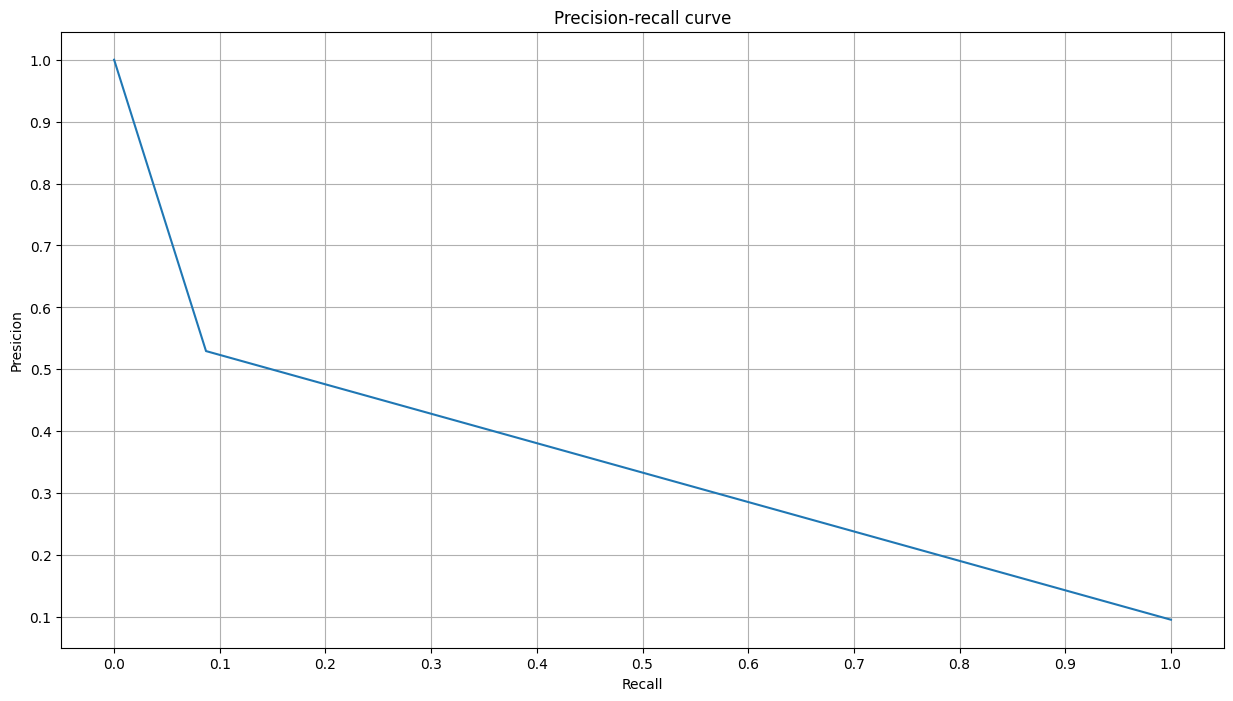

In [70]:
get_metrics(model, X_test, y_test, threshold=0.5)

Реализуем случайный лес.

In [84]:
from tqdm import tqdm


class CustomRandomForest:
    def __init__(self, n_estimators=10, max_depth=5, max_features=20):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.estimators = []

    def fit(self, X, y):
        for _ in tqdm(range(self.n_estimators)):
            indices = np.random.choice(X.shape[0], replace=True, size=X.shape[0])
            if self.max_features:
                num_features = min(self.max_features, X.shape[1])
                selected_features = np.random.choice(X.shape[1], num_features, replace=False)
                X_subset = X.iloc[indices].iloc[:, selected_features]
            else:
                X_subset = X.iloc[indices]
            y_subset = y.iloc[indices]
            tree = CustomDecisionTree(max_depth=self.max_depth)
            tree.fit(X_subset, y_subset)
            self.estimators.append((selected_features, tree))

    def predict(self, X):
        y_preds = []
        for features, tree in self.estimators:
            if features is not None:
                X_subset = X.iloc[:, features]
            else:
                X_subset = X.iloc
            y_pred = tree.predict(X_subset)
            y_preds.append(y_pred)
        y_pred_majority = []
        for i in range(len(X)):
            preds = [y_preds[j][i] for j in range(self.n_estimators)]
            pred, counts = np.unique(preds, return_counts=True)
            y_pred_majority.append(pred[np.argmax(counts)])
        return np.array(y_pred_majority)

In [85]:
model = CustomRandomForest()
model.fit(X_train, y_train)

100%|██████████| 10/10 [18:17<00:00, 109.76s/it]


Accuracy =  0.9058853673919899
Precision =  0.5752895752895753
Recall =  0.06140531629919637


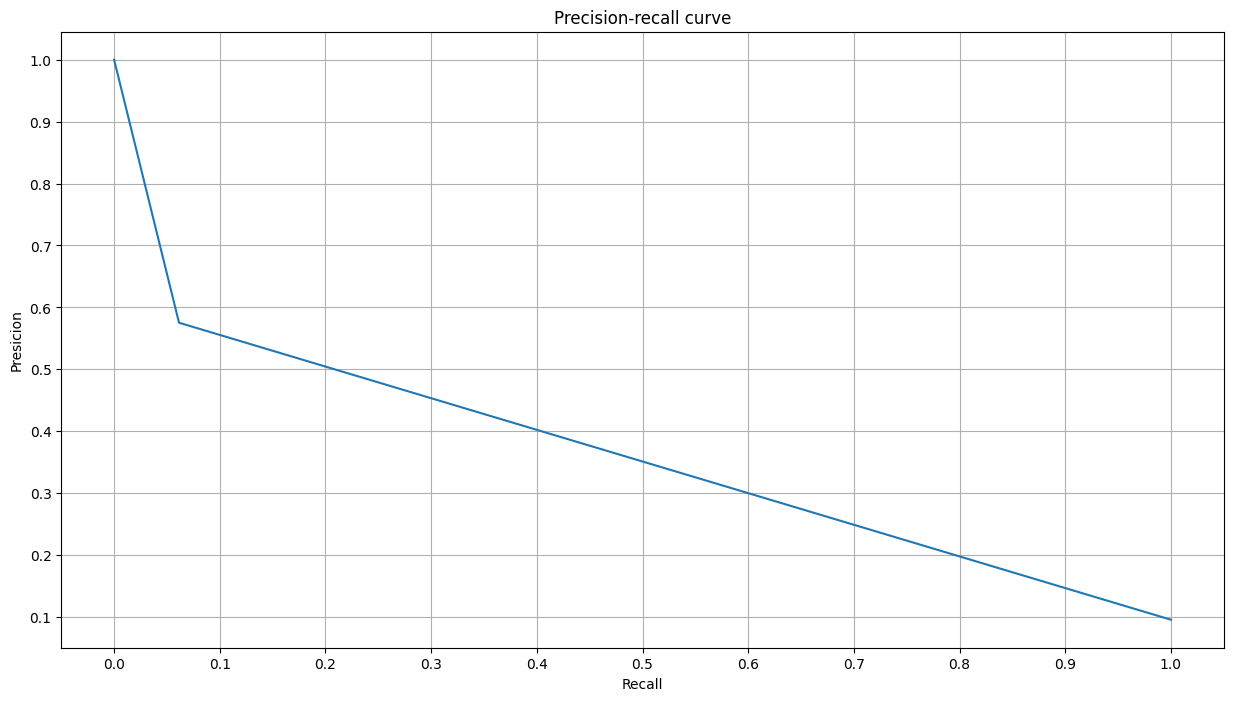

In [86]:
get_metrics(model, X_test, y_test, threshold=0.5)

Реализуем градиентный бустинг.

In [42]:
from tqdm import tqdm


class CustomGradientBoosting:
    def __init__(self, n_estimators=3, learning_rate=0.1, max_depth=5):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []

    def fit(self, X, y):
        F = np.zeros(y.shape[0])

        for _ in tqdm(range(self.n_estimators)):
            residuals = self._compute_residuals(y, F)
            tree = CustomDecisionTree(max_depth=self.max_depth)
            tree.fit(X, residuals)

            self.estimators.append(tree)
            F += self.learning_rate * tree.predict(X)

    def predict(self, X):
        F = np.zeros(X.shape[0])
        for tree in self.estimators:
            F += self.learning_rate * tree.predict(X)
        return F

    def _compute_residuals(self, y, F):
        return y - F

In [43]:
model = CustomGradientBoosting()
model.fit(X_train, y_train)

100%|██████████| 3/3 [06:02<00:00, 120.90s/it]


Accuracy =  0.9053729107537054
Precision =  0.5415335463258786
Recall =  0.06985369874304553


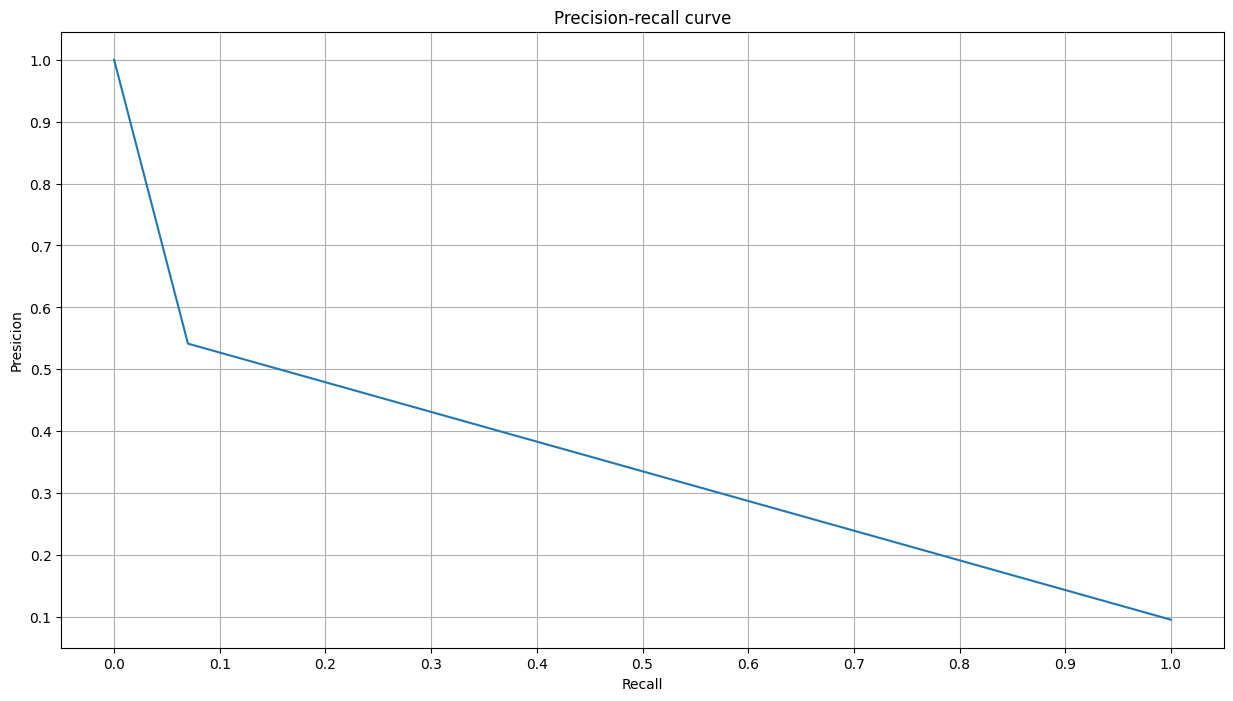

In [47]:
get_metrics(model, X_test, y_test, threshold=0.5)

#### Обучение этих же моделей из sklearn

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

Accuracy =  0.7516359192683696
Precision =  0.24010465584328458
Recall =  0.7374819699155162


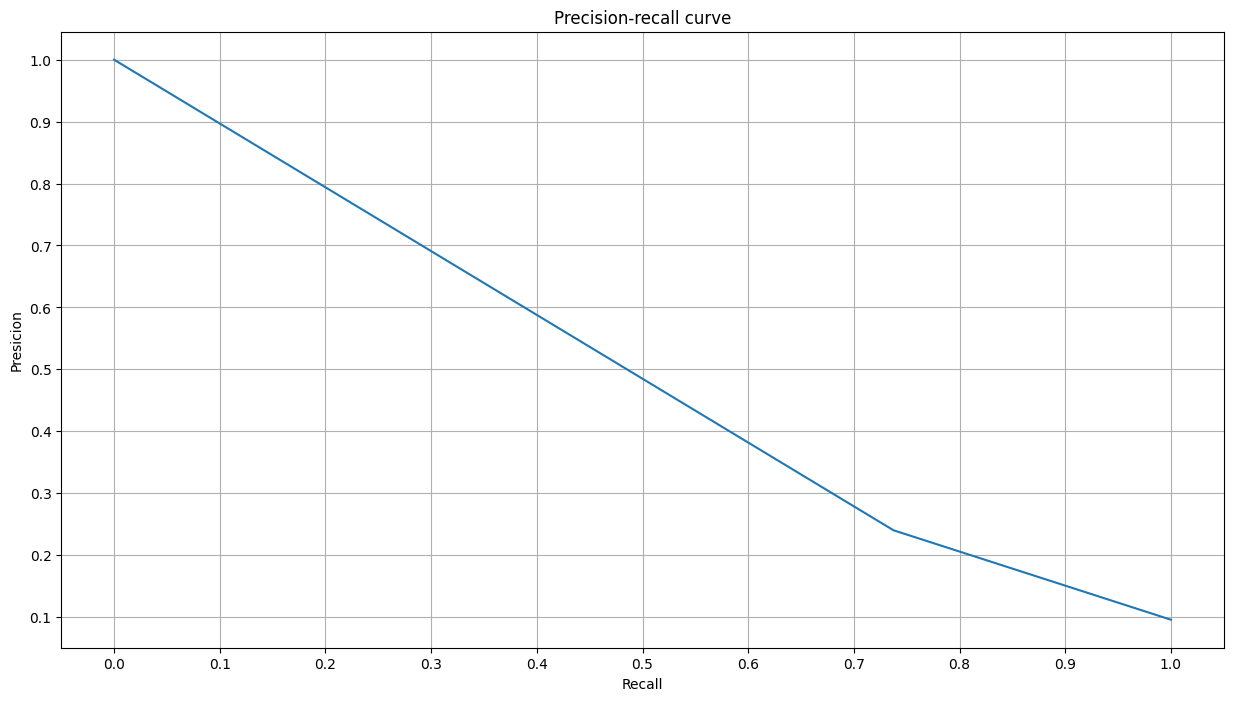

In [16]:
get_metrics(model, X_test, y_test, threshold=0.5)

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=5, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

Accuracy =  0.7196862188584043
Precision =  0.2292666011674276
Recall =  0.8174325159695034


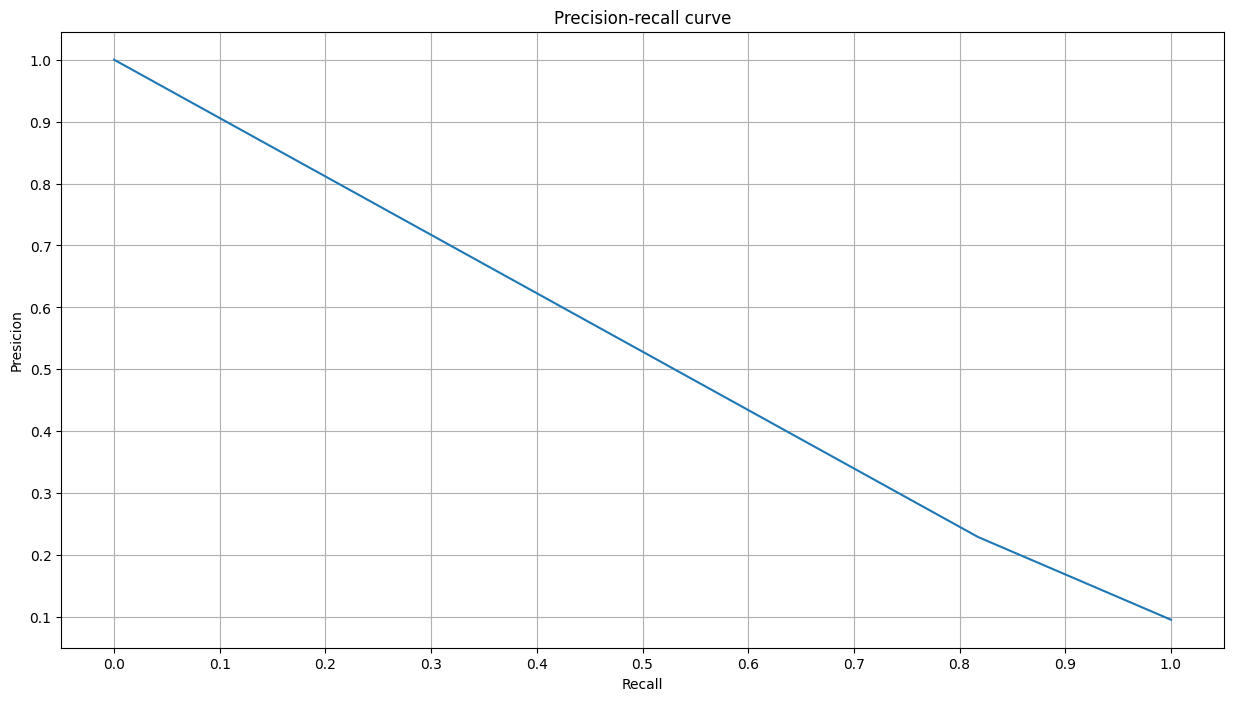

In [26]:
get_metrics(model, X_test, y_test, threshold=0.5)

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=500, max_depth=5)
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=500)

Accuracy =  0.9065752128666036
Precision =  0.5541706615532119
Recall =  0.11910158664743457


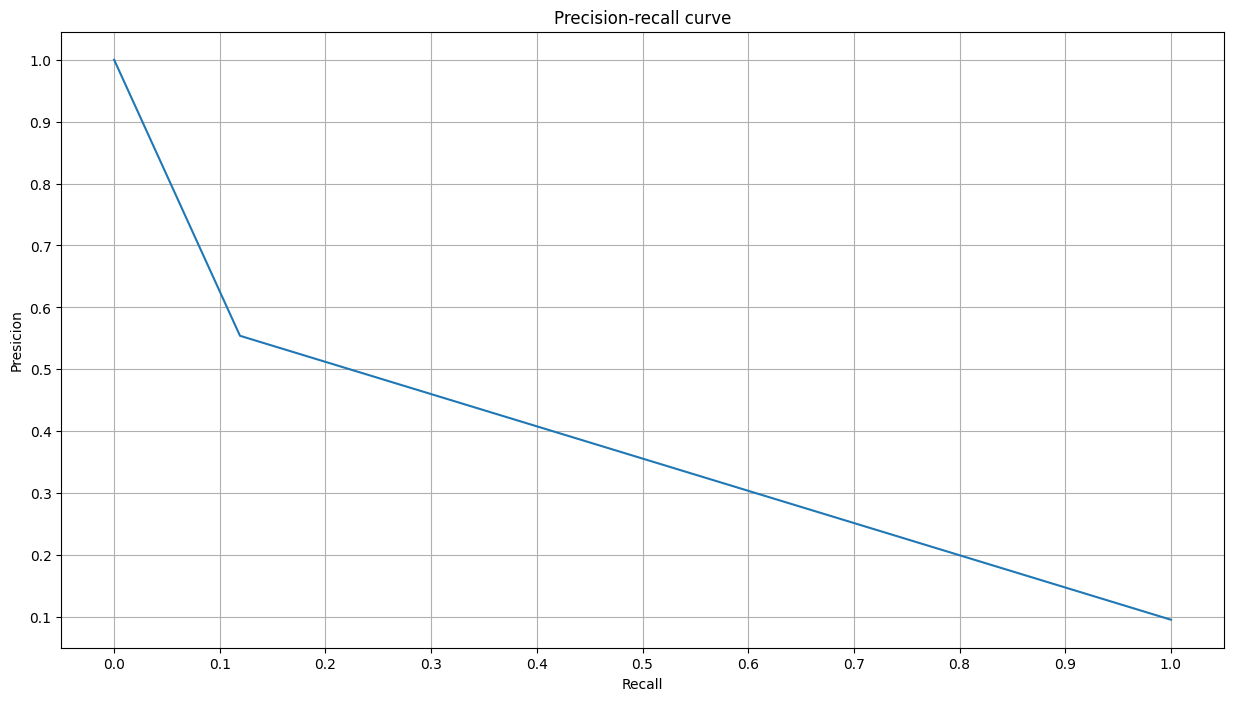

In [37]:
get_metrics(model, X_test, y_test, threshold=0.5)

Модели из sklearn оказались лучше, сравнивая при recall = 0.7.